# Trading Strategies V: Factor Z Scores

Libraries:

In [1]:
# Working with data:
import numpy as np
import pandas as pd  

# Use pipeline:
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline

# Data sets
from quantopian.pipeline.data    import USEquityPricing, Fundamentals, factset
from quantopian.pipeline.factors import Returns, SimpleBeta

# Filters
from quantopian.pipeline.filters import StaticAssets
from quantopian.pipeline.filters.fundamentals import IsDepositaryReceipt, IsPrimaryShare

In [2]:
FIRST_DATE = '2003-1-4'    # First available 2002-1-4, but we want to get 252-day beta 
TODAY      = '2020-4-22'

### Get data
Use SPY as benchmark:

In [3]:
spy = get_pricing(['SPY'], FIRST_DATE, TODAY, fields='close_price')
spy[:3]

,Equity(8554 [SPY])
2003-01-06 00:00:00+00:00,66.639
2003-01-07 00:00:00+00:00,66.232
2003-01-08 00:00:00+00:00,65.259


Turn spy dataframe into series starting with value 1:

In [33]:
spy = spy.iloc[:,0].divide(spy.iloc[0,0])

In [34]:
spy

2003-01-06 00:00:00+00:00    1.000000
2003-01-07 00:00:00+00:00    0.993892
2003-01-08 00:00:00+00:00    0.979291
2003-01-09 00:00:00+00:00    0.998619
2003-01-10 00:00:00+00:00    0.998304
2003-01-13 00:00:00+00:00    0.997299
2003-01-14 00:00:00+00:00    1.003346
2003-01-15 00:00:00+00:00    0.989181
2003-01-16 00:00:00+00:00    0.986059
2003-01-17 00:00:00+00:00    0.971608
2003-01-21 00:00:00+00:00    0.955987
2003-01-22 00:00:00+00:00    0.945362
2003-01-23 00:00:00+00:00    0.956317
2003-01-24 00:00:00+00:00    0.927040
2003-01-27 00:00:00+00:00    0.913069
2003-01-28 00:00:00+00:00    0.924744
2003-01-29 00:00:00+00:00    0.931827
2003-01-30 00:00:00+00:00    0.910578
2003-01-31 00:00:00+00:00    0.921743
2003-02-03 00:00:00+00:00    0.926349
2003-02-04 00:00:00+00:00    0.914224
2003-02-05 00:00:00+00:00    0.908852
2003-02-06 00:00:00+00:00    0.903840
2003-02-07 00:00:00+00:00    0.894356
2003-02-10 00:00:00+00:00    0.901334
2003-02-11 00:00:00+00:00    0.893501
2003-02-12 0

Individual firms:

In [13]:
def make_pipeline():
    
    universe = IsPrimaryShare() & ~IsDepositaryReceipt()       # Primary shares and not ADRs.
            
    columns = {
        'Price'  : USEquityPricing.close.latest,   
        'Return' : Returns(window_length=2),   
        'Mcap'   : Fundamentals.market_cap.latest / 10**9, 
        'EY'     : Fundamentals.earning_yield.latest,
        'Beta'   : SimpleBeta(target=symbols('SPY'),regression_length=252),        
    } 
        
    return Pipeline( columns=columns, screen=universe )    

data = run_pipeline( make_pipeline(), FIRST_DATE, TODAY )
data[:4]

Beta      EY       Mcap  \
2003-01-06 00:00:00+00:00 Equity(2 [HWM])    1.169598  0.0255  19.232478   
                          Equity(6 [AACE])  -0.039899  0.1164   0.094069   
                          Equity(14 [AALA])       NaN -0.5969   0.005670   
                          Equity(21 [AAME])  0.312033  0.0613   0.034839   

                                              Price    Return  
2003-01-06 00:00:00+00:00 Equity(2 [HWM])    23.780  0.008054  
                          Equity(6 [AACE])    9.740  0.041711  
                          Equity(14 [AALA])     NaN       NaN  
                          Equity(21 [AAME])   1.661  0.007277

In [15]:
PRICE = data.Price.unstack()
RET   = data.Return.unstack()
MCAP  = data.Mcap.unstack()
EY    = data.EY.unstack()
BETA  = data.Beta.unstack()

### Our rebalancing algorithm

In [35]:
def get_rebalance_dates(frequency):
    if   frequency == 'A': group = PRICE.groupby( PRICE.index.year)
    elif frequency == 'Q': group = PRICE.groupby([PRICE.index.year, PRICE.index.quarter])  
    elif frequency == 'M': group = PRICE.groupby([PRICE.index.year, PRICE.index.month])    
    elif frequency == 'W': group = PRICE.groupby([PRICE.index.year, PRICE.index.week])     
    return PRICE.index[:1].union(group.tail(1).index) 

def calc_returns(start, end, assets):
    price_ret = PRICE.loc[start:end,assets].ffill().pct_change()
    return RET.loc[start:end,assets][1:].fillna(price_ret).add(1).cumprod() 


def run_backtest(frequency):
    rebalance_dates = get_rebalance_dates(frequency)    
    portfolio_value = pd.Series(1,index=[rebalance_dates[0]])

    for i in range(len(rebalance_dates)-1):
        start_date = rebalance_dates[i]
        end_date   = rebalance_dates[i+1]
        assets_we_can_buy = PRICE.loc[start_date].dropna().index
        assets            = select_assets(start_date, assets_we_can_buy)
        weights           = select_weights(start_date, assets)
        cum_ret               = calc_returns(start_date, end_date, assets)
        asset_values          = portfolio_value[-1] * weights  * cum_ret  
        portfolio_value       = portfolio_value.append(asset_values.sum(axis=1)) 
        
    return portfolio_value

### Sorting firms by characteristics:

Let's choose equal weights for now:

In [36]:
def select_weights(date, assets):
    return pd.Series(1/len(assets),index=assets) 

Buy the smallest 500 out of the largest 3000 firms:

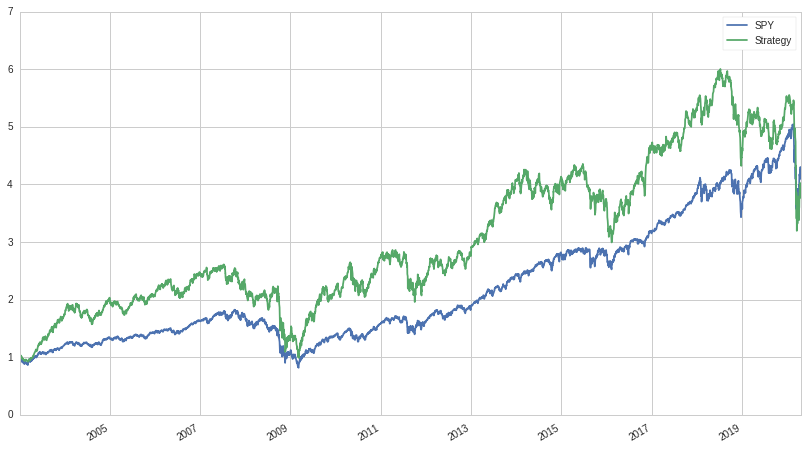

In [37]:
def select_assets(date, can_buy):  
    return MCAP.loc[date,can_buy].nlargest(3000).nsmallest(500).index

pd.DataFrame({'SPY':spy, 'Strategy':run_backtest('Q')}).plot()

Alternatively we can also write it like this:

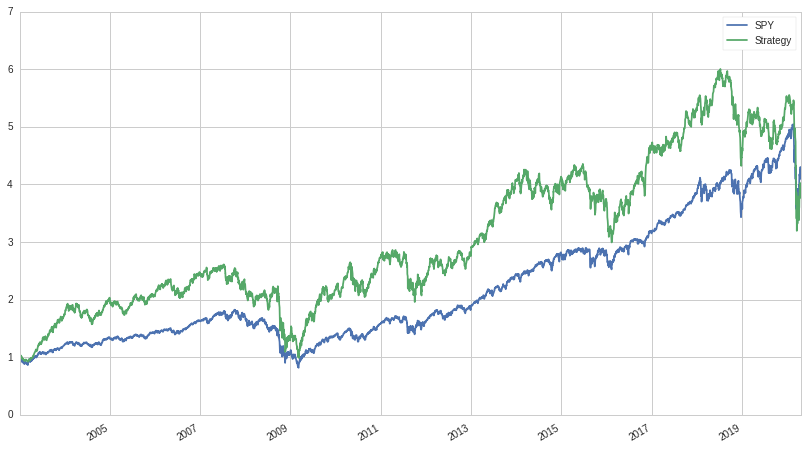

In [39]:
def select_assets(date, can_buy):  
    universe    = MCAP.loc[date,can_buy].nlargest(3000).index
    small_firms = MCAP.loc[date,universe].nsmallest(500).index
    return small_firms

pd.DataFrame({'SPY':spy, 'Strategy':run_backtest('Q')}).plot()

Suppose we select high beta stocks like this:
1. investible universe: largest 3000 firms
1. select 500 firms with highest beta out of investible universe

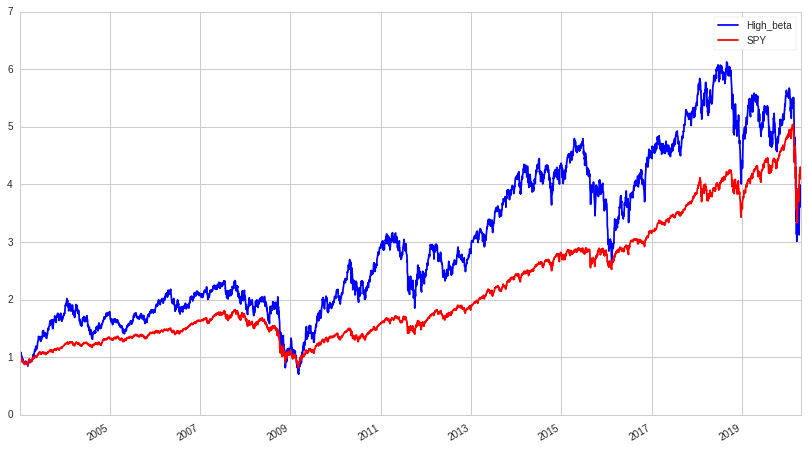

In [48]:
def select_assets(date, can_buy):  
    universe  = MCAP.loc[date,can_buy].nlargest(3000).index
    high_beta = BETA.loc[date,universe].nlargest(500).index
    return high_beta

colors = {'SPY':'Red','High_beta':'Blue'}

compare = pd.DataFrame({'SPY':spy, 'High_beta':run_backtest('Q')})
compare.plot(color = [colors.get(x) for x in compare.columns] )

Same procedure for low beta staocks:

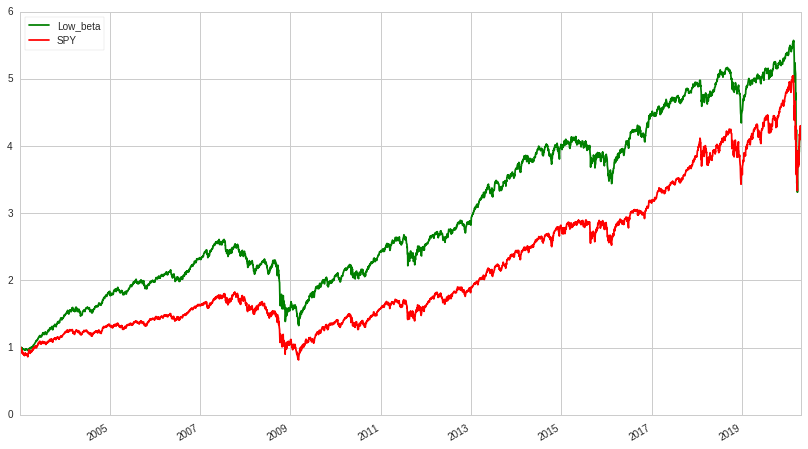

In [54]:

def select_assets(date, can_buy):  
    universe  = MCAP.loc[date,can_buy].nlargest(3000).index
    low_beta = BETA.loc[date,universe].nsmallest(500).index
    return low_beta

colors = {'SPY':'Red','High_beta':'Blue', 'Low_beta': 'Green'}

compare = pd.DataFrame({'SPY':spy, 'Low_beta':run_backtest('Q')})

compare.plot(color = [colors.get(x) for x in compare.columns] )


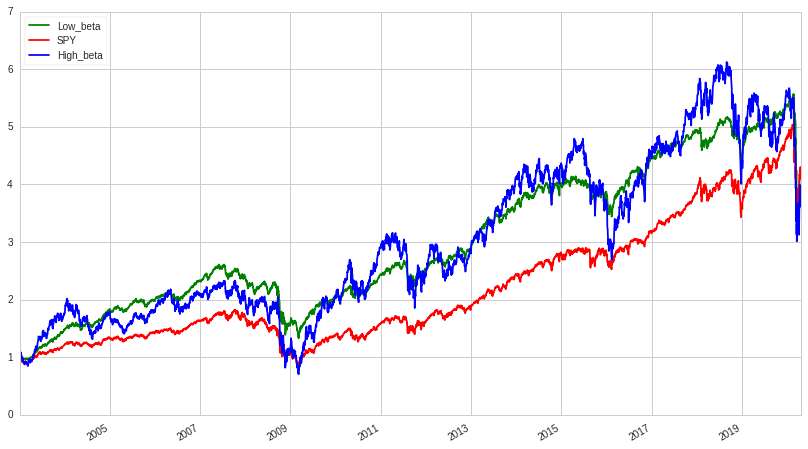

In [55]:
def select_assets(date, can_buy):  
    universe  = MCAP.loc[date,can_buy].nlargest(3000).index
    high_beta = BETA.loc[date,universe].nlargest(500).index
    return high_beta

compare['High_beta'] = run_backtest('Q')

compare.plot(color = [colors.get(x) for x in compare.columns] )


Suppose we select high earnings-yield stocks like this:
1. investible universe: largest 3000 firms
1. select 500 firms with highest earnings yield 

In [ ]:
def select_assets(date, can_buy):  
    universe = 
    high_ey  = 
    return 

pd.DataFrame({'SPY':spy, 'Strategy':run_backtest('Q')}).plot()

Suppose we select firms that have high earnings-yields and low beta like this:
1. investible universe: largest 3000 firms
1. select 500 firms with highest earnings yield 
1. select 100 firms with lowest beta 

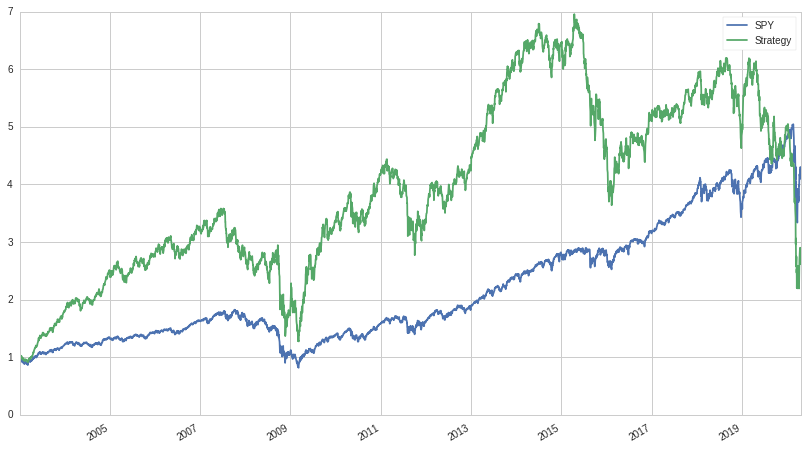

In [58]:
def select_assets(date, can_buy):  
    universe = MCAP.loc[date,can_buy].nlargest(3000).index
    high_ey  = EY.loc[date, universe].nlargest(100).index
    low_beta = BETA.loc[date, high_ey].nsmallest(500).index
    return low_beta

pd.DataFrame({'SPY':spy, 'Strategy':run_backtest('Q')}).plot()

Suppose we select firms that have high earnings-yields and low beta like this:
1. investible universe: largest 3000 firms
1. select 500 firms with lowest beta 
1. select 100 firms with highest earnings yield 

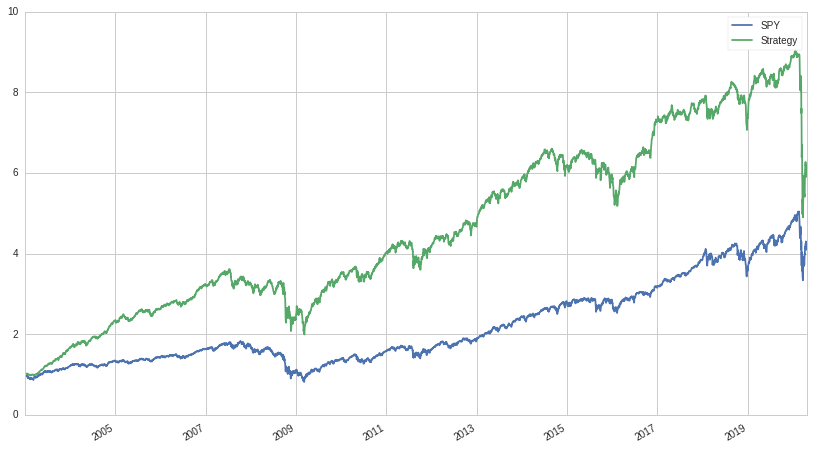

In [56]:
def select_assets(date, can_buy):  
    universe = MCAP.loc[date,can_buy].nlargest(3000).index
    low_beta = BETA.loc[date, universe].nsmallest(500).index
    high_ey  = EY.loc[date, low_beta].nlargest(100).index
    return high_ey

pd.DataFrame({'SPY':spy, 'Strategy':run_backtest('Q')}).plot()

Below is the correct way to do it using interection

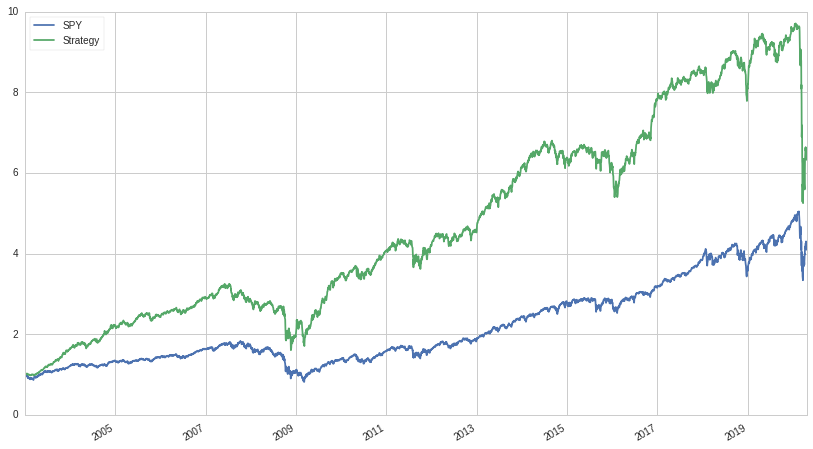

In [64]:
def select_assets(date, can_buy):  
    universe = MCAP.loc[date,can_buy].nlargest(3000).index
    low_beta = BETA.loc[date, universe].nsmallest(500).index
    high_ey  = EY.loc[date, universe].nlargest(500).index
    return low_beta.intersection(high_ey)


pd.DataFrame({'SPY':spy, 'Strategy':run_backtest('A')}).plot()

### Selecting firms with Z Scores
1. each firms gets a score for each characteristic
1. calculate (weighted) average score for each firm
1. select firms with highest average score

Example characteristics:
- earnings yield
- beta

Example firm:
- earnings yield = 0.08
- beta = 1.2

Problems: earnings yield and beta come from different distributions so we can't just average them ((1.2 + 0.08)/2 dosn't make much sense).

Solution: standardize the characteristics:
$$
\frac{x-E[x]}{\sigma_x}
$$
And the average these standardized values ("Z Scores")

Another problem: outliers might have a disproportionate effect on result.     
Solution: remove outliers for example by removing all data below 1% quantile and above 99% quantile

In [65]:
def calculate_z_score(pd_series):
    x = pd_series.dropna()
    x_clean = x[ (x>x.quantile(0.01)) & (x<x.quantile(0.99)) ]
    return (x_clean-x_clean.mean()) / x_clean.std()

Run the function like this:

In [69]:
date = '2018-1-3'

can_buy  = PRICE.loc[date].dropna().index
universe = MCAP.loc[date,can_buy].nlargest(20).index

ey = calculate_z_score(EY.loc[date,universe])
ey.nlargest(20)

Equity(25006 [JPM])       1.620571
Equity(8151 [WFC])        1.551917
Equity(3951 [INTC])       1.361212
Equity(700 [BAC])         1.185763
Equity(6653 [T])          0.857750
Equity(24 [AAPL])         0.804352
Equity(5923 [PFE])        0.117813
Equity(5938 [PG])        -0.118661
Equity(4151 [JNJ])       -0.126289
Equity(11100 [BRK_B])    -0.347507
Equity(3496 [HD])        -0.355136
Equity(8229 [WMT])       -0.370392
Equity(8347 [XOM])       -0.522956
Equity(5061 [MSFT])      -0.767059
Equity(42950 [FB])       -1.110328
Equity(26578 [GOOG_L])   -1.148469
Equity(23112 [CVX])      -1.224752
Equity(35920 [V])        -1.407829
Name: 2018-01-03 00:00:00+00:00, dtype: float64

Beta:

In [67]:
beta = calculate_z_score(BETA.loc[date,universe])
beta.nlargest(20)

Equity(25006 [JPM])       1.369452
Equity(8151 [WFC])        1.364943
Equity(24 [AAPL])         1.098799
Equity(16841 [AMZN])      0.980040
Equity(42950 [FB])        0.883705
Equity(5061 [MSFT])       0.860307
Equity(26578 [GOOG_L])    0.763565
Equity(3951 [INTC])       0.569804
Equity(11100 [BRK_B])     0.172804
Equity(35920 [V])         0.126974
Equity(6653 [T])         -0.708209
Equity(3496 [HD])        -0.976584
Equity(8347 [XOM])       -0.977307
Equity(5923 [PFE])       -0.977675
Equity(21839 [VZ])       -0.998510
Equity(23112 [CVX])      -1.003389
Equity(4151 [JNJ])       -1.253181
Equity(8229 [WMT])       -1.295537
Name: 2018-01-03 00:00:00+00:00, dtype: float64

Earnings yield and beta combined:

In [74]:
(0.5 * ey + -0.5 * beta).nlargest(10)

Equity(6653 [T])       0.782979
Equity(4151 [JNJ])     0.563446
Equity(5923 [PFE])     0.547744
Equity(8229 [WMT])     0.462572
Equity(3951 [INTC])    0.395704
Equity(3496 [HD])      0.310724
Equity(8347 [XOM])     0.227175
Equity(25006 [JPM])    0.125560
Equity(8151 [WFC])     0.093487
Equity(23112 [CVX])   -0.110682
Name: 2018-01-03 00:00:00+00:00, dtype: float64

Now apply this ranging methodology to our asset seletion method:
1. investible universe: largest 3000 firms
1. calculate z-scores for each characteristic
1. select firms with highest combined z-score

In [111]:
def get_rebalance_dates(frequency):
    if   frequency == 'A': group = PRICE.groupby( PRICE.index.year)
    elif frequency == 'Q': group = PRICE.groupby([PRICE.index.year, PRICE.index.quarter])  
    elif frequency == 'M': group = PRICE.groupby([PRICE.index.year, PRICE.index.month])    
    elif frequency == 'W': group = PRICE.groupby([PRICE.index.year, PRICE.index.week])     
    return PRICE.index[:1].union(group.tail(1).index) 

def calc_returns(start, end, assets):
    price_ret = PRICE.loc[start:end,assets].ffill().pct_change()
    return RET.loc[start:end,assets][1:].fillna(price_ret).add(1).cumprod() 


def run_backtest(frequency):
    rebalance_dates = get_rebalance_dates(frequency)    
    portfolio_value = pd.Series(1,index=[rebalance_dates[0]])

    for i in range(len(rebalance_dates)-1):
        start_date = rebalance_dates[i]
        end_date   = rebalance_dates[i+1]
        assets_we_can_buy = PRICE.loc[start_date].dropna().index
        assets            = select_assets(start_date, assets_we_can_buy).index
        weights           = select_assets(start_date, assets_we_can_buy)
        cum_ret               = calc_returns(start_date, end_date, assets)
        asset_values          = portfolio_value[-1] * weights  * cum_ret  
        portfolio_value       = portfolio_value.append(asset_values.sum(axis=1)) 
        
    return portfolio_value

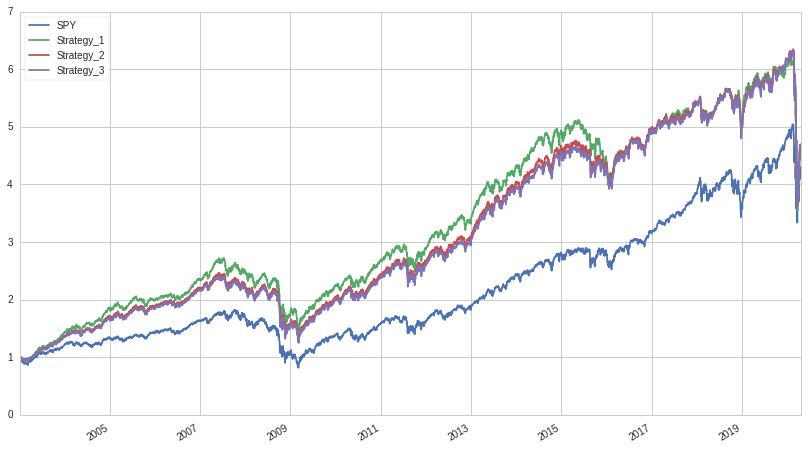

In [118]:
def select_weights(date, assets):
    return pd.Series(1/len(assets),index=assets) 

def select_assets(date, can_buy):  
    universe = MCAP.loc[date,can_buy].nlargest(2000).index
    z_ey   = calculate_z_score(EY.loc[date,universe])
    z_beta = calculate_z_score(-BETA.loc[date,universe])
    score = (0.5*z_ey + 0.5*z_beta).nlargest(400)
    weight_series = score**4 / ((score**4).sum())
    return weight_series

compare = pd.DataFrame({'SPY':spy, 'Strategy_1':run_backtest('Q')})

def select_assets(date, can_buy):  
    universe = MCAP.loc[date,can_buy].nlargest(2000).index
    z_ey   = calculate_z_score(EY.loc[date,universe])
    z_beta = calculate_z_score(-BETA.loc[date,universe])
    score = (0.5*z_ey + 0.5*z_beta).nlargest(400)
    weight_series = score**1 / ((score**1).sum())
    return weight_series
compare['Strategy_2'] = run_backtest('Q')

def select_assets(date, can_buy):  
    universe = MCAP.loc[date,can_buy].nlargest(2000).index
    z_ey   = calculate_z_score(EY.loc[date,universe])
    z_beta = calculate_z_score(-BETA.loc[date,universe])
    score = (0.5*z_ey + 0.5*z_beta).nlargest(400)
    weight_series = pd.Series(1/len(score.index),index=score.index)
    return weight_series
compare['Strategy_3'] = run_backtest('Q')

compare.plot()

### use st.norm.cdf() to turn z score into probability
### Even better use this https://machinelearningmastery.com/empirical-distribution-function-in-python/

## scipy.stats.percentileofscore example below

In [4]:
import pandas as pd
from scipy import stats

data = {'symbol':'FB','date':['2012-05-18','2012-05-21','2012-05-22','2012-05-23'],'close':[38.23,34.03,31.00,32.00]}

df = pd.DataFrame(data)

close = df['close']

df_2= df.close.rank(pct=True)

In [3]:
df

,close,date,symbol
0,38.23,2012-05-18,FB
1,34.03,2012-05-21,FB
2,31.00,2012-05-22,FB
3,32.00,2012-05-23,FB


In [5]:
df_2

0    1.00
1    0.75
2    0.25
3    0.50
Name: close, dtype: float64

In [6]:
df_2-0.5

0    0.50
1    0.25
2   -0.25
3    0.00
Name: close, dtype: float64